# Model Interpretation

This notebook provides detailed interpretation of the trained fraud detection models, including feature importance, model coefficients, and feature contribution analysis.

## Objectives

1. **Feature Importance**: Identify which features are most influential in fraud prediction
2. **Model Coefficients**: Understand how Logistic Regression weights each feature
3. **Feature Comparison**: Compare feature importance across different models
4. **Insights**: Derive actionable insights for fraud detection


In [1]:
# Imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import PipelineModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10


In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("Fraud Detection Model Interpretation").getOrCreate()

# Load models
lr_model = PipelineModel.load("../models/lr_baseline_model")
gbt_model = PipelineModel.load("../models/gbt_baseline_model")
rf_model = PipelineModel.load("../models/rf_baseline_model")

# Define feature columns (same as in training)
feature_cols = [
    "TX_AMOUNT",
    "LOG_TX_AMOUNT",
    "TX_TIME_SECONDS",
    "TX_TIME_DAYS",
    "TX_HOUR",
    "IS_NIGHT",
    "IS_WEEKEND"
]

print("Models and features loaded successfully!")
print(f"\nFeatures: {feature_cols}")


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/02 00:40:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/01/02 00:40:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
26/01/02 00:40:34 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
26/01/02 00:40:34 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
26/01/02 00:40:34 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


Models and features loaded successfully!

Features: ['TX_AMOUNT', 'LOG_TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS', 'TX_HOUR', 'IS_NIGHT', 'IS_WEEKEND']


## 1. Logistic Regression Coefficients

Logistic Regression provides interpretable coefficients that show the direction and magnitude of each feature's impact on fraud prediction. Positive coefficients indicate increased fraud likelihood, while negative coefficients indicate decreased fraud likelihood.


In [3]:
# Extract Logistic Regression model from pipeline
lr_stages = lr_model.stages
lr_classifier = None
scaler = None
for stage in lr_stages:
    if hasattr(stage, 'coefficients'):
        lr_classifier = stage
    elif hasattr(stage, 'std'):
        scaler = stage

if lr_classifier is None:
    raise ValueError("Could not find LogisticRegression model in pipeline")

# Get coefficients
coefficients = lr_classifier.coefficients.toArray()
intercept = lr_classifier.intercept

# Create DataFrame for coefficients
lr_coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("=" * 60)
print("LOGISTIC REGRESSION COEFFICIENTS")
print("=" * 60)
print(f"\nIntercept: {intercept:.6f}")
print(f"\nCoefficients (sorted by absolute value):\n")
print(lr_coef_df.to_string(index=False))
print("=" * 60)


LOGISTIC REGRESSION COEFFICIENTS

Intercept: -6.022281

Coefficients (sorted by absolute value):

        Feature  Coefficient  Abs_Coefficient
      TX_AMOUNT    18.286969        18.286969
  LOG_TX_AMOUNT    -3.613625         3.613625
   TX_TIME_DAYS     0.018611         0.018611
TX_TIME_SECONDS     0.018311         0.018311
        TX_HOUR    -0.007548         0.007548
     IS_WEEKEND    -0.003727         0.003727
       IS_NIGHT    -0.001568         0.001568


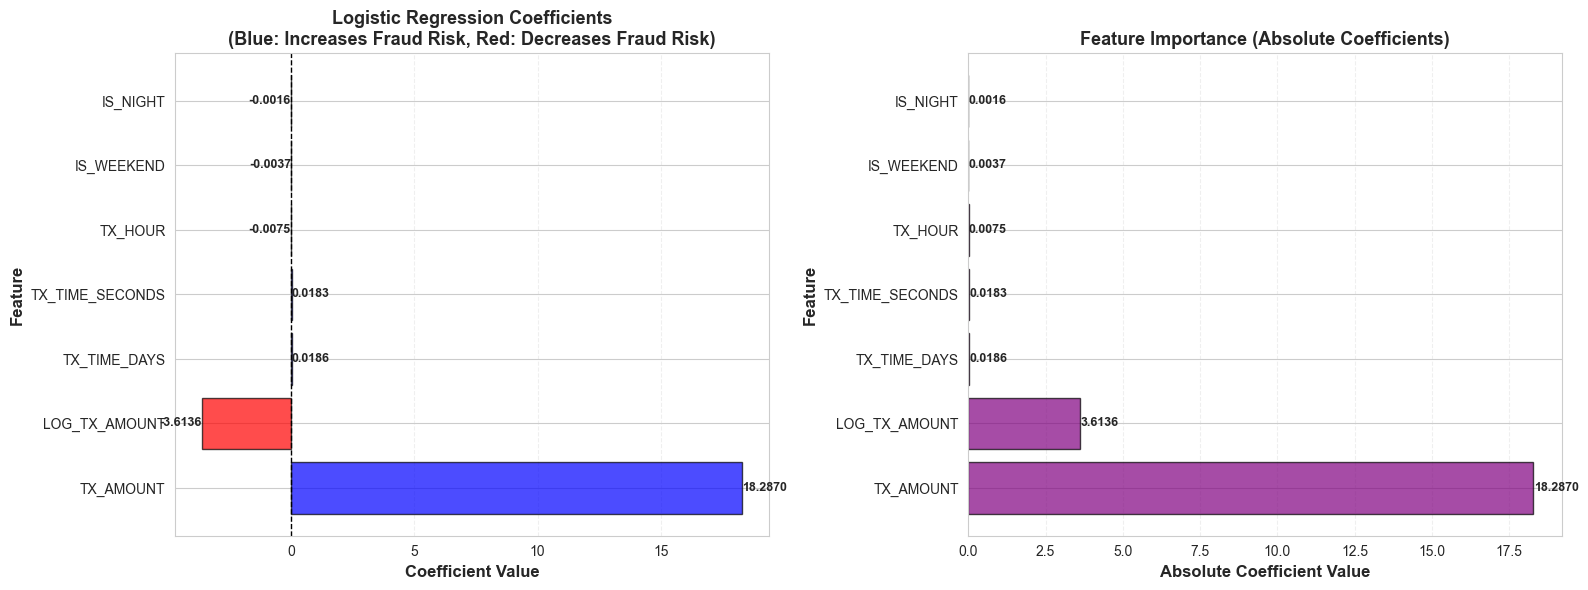

In [4]:
# Visualize Logistic Regression Coefficients
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Coefficients with direction
ax1 = axes[0]
colors = ['red' if x < 0 else 'blue' for x in lr_coef_df['Coefficient']]
bars = ax1.barh(lr_coef_df['Feature'], lr_coef_df['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax1.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax1.set_title('Logistic Regression Coefficients\n(Blue: Increases Fraud Risk, Red: Decreases Fraud Risk)', 
              fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, lr_coef_df['Coefficient'])):
    width = bar.get_width()
    label_x = width + 0.01 if width >= 0 else width - 0.01
    ax1.text(label_x, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', ha='left' if width >= 0 else 'right', 
             va='center', fontweight='bold', fontsize=9)

# 2. Absolute coefficients (importance)
ax2 = axes[1]
bars2 = ax2.barh(lr_coef_df['Feature'], lr_coef_df['Abs_Coefficient'], 
                 color='purple', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Absolute Coefficient Value', fontsize=12, fontweight='bold')
ax2.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax2.set_title('Feature Importance (Absolute Coefficients)', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars2, lr_coef_df['Abs_Coefficient']):
    width = bar.get_width()
    ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{val:.4f}', ha='left', va='center', 
             fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()


## 2. Gradient Boosting Trees Feature Importance

Gradient Boosting Trees (GBT) provide feature importance based on how much each feature contributes to reducing impurity across all trees in the ensemble. Higher values indicate more important features for fraud prediction.


In [5]:
# Extract GBT model from pipeline
gbt_stages = gbt_model.stages
gbt_classifier = None
for stage in gbt_stages:
    if hasattr(stage, 'featureImportances'):
        gbt_classifier = stage
        break

if gbt_classifier is None:
    raise ValueError("Could not find GBTClassifier model in pipeline")

# Get feature importances
gbt_importances = gbt_classifier.featureImportances.toArray()

# Create DataFrame
gbt_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': gbt_importances
}).sort_values('Importance', ascending=False)

print("=" * 60)
print("GRADIENT BOOSTING TREES FEATURE IMPORTANCE")
print("=" * 60)
print(gbt_importance_df.to_string(index=False))
print("=" * 60)


GRADIENT BOOSTING TREES FEATURE IMPORTANCE
        Feature  Importance
      TX_AMOUNT    0.788199
  LOG_TX_AMOUNT    0.211025
   TX_TIME_DAYS    0.000370
        TX_HOUR    0.000279
TX_TIME_SECONDS    0.000104
     IS_WEEKEND    0.000020
       IS_NIGHT    0.000002


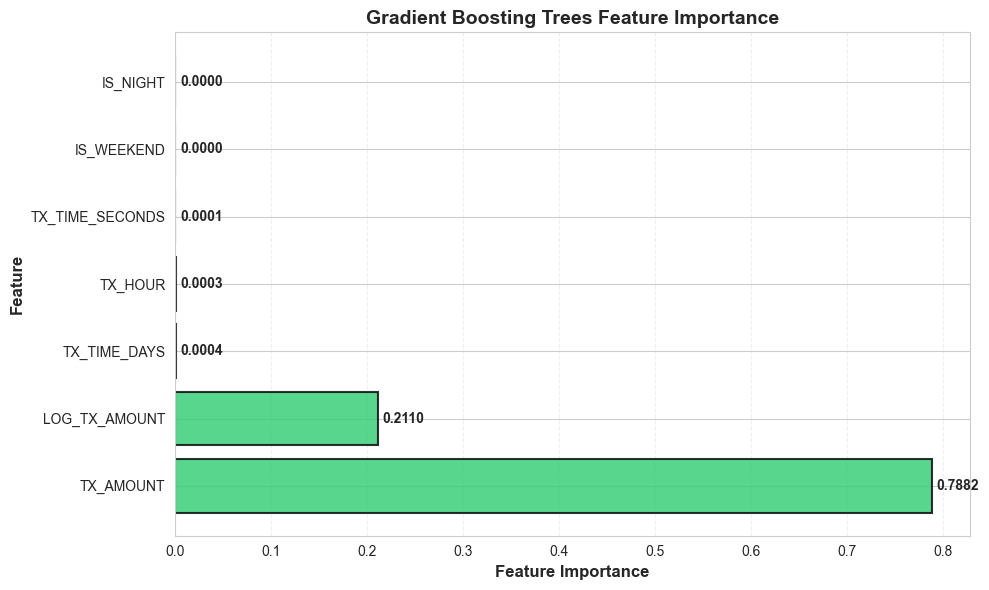

In [6]:
# Visualize GBT Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(gbt_importance_df['Feature'], gbt_importance_df['Importance'], 
               color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Gradient Boosting Trees Feature Importance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars, gbt_importance_df['Importance']):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
           f'{val:.4f}', ha='left', va='center', 
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## 3. Random Forest Feature Importance

Random Forest also provides feature importance based on impurity reduction. Comparing GBT and RF importance can reveal which features are consistently important across different tree-based algorithms.


In [7]:
# Extract Random Forest model from pipeline
rf_stages = rf_model.stages
rf_classifier = None
for stage in rf_stages:
    if hasattr(stage, 'featureImportances'):
        rf_classifier = stage
        break

if rf_classifier is None:
    raise ValueError("Could not find RandomForestClassifier model in pipeline")

# Get feature importances
rf_importances = rf_classifier.featureImportances.toArray()

# Create DataFrame
rf_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_importances
}).sort_values('Importance', ascending=False)

print("=" * 60)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("=" * 60)
print(rf_importance_df.to_string(index=False))
print("=" * 60)


RANDOM FOREST FEATURE IMPORTANCE
        Feature   Importance
      TX_AMOUNT 5.677959e-01
  LOG_TX_AMOUNT 4.321969e-01
TX_TIME_SECONDS 4.639260e-06
   TX_TIME_DAYS 2.183404e-06
        TX_HOUR 4.261672e-07
       IS_NIGHT 0.000000e+00
     IS_WEEKEND 0.000000e+00


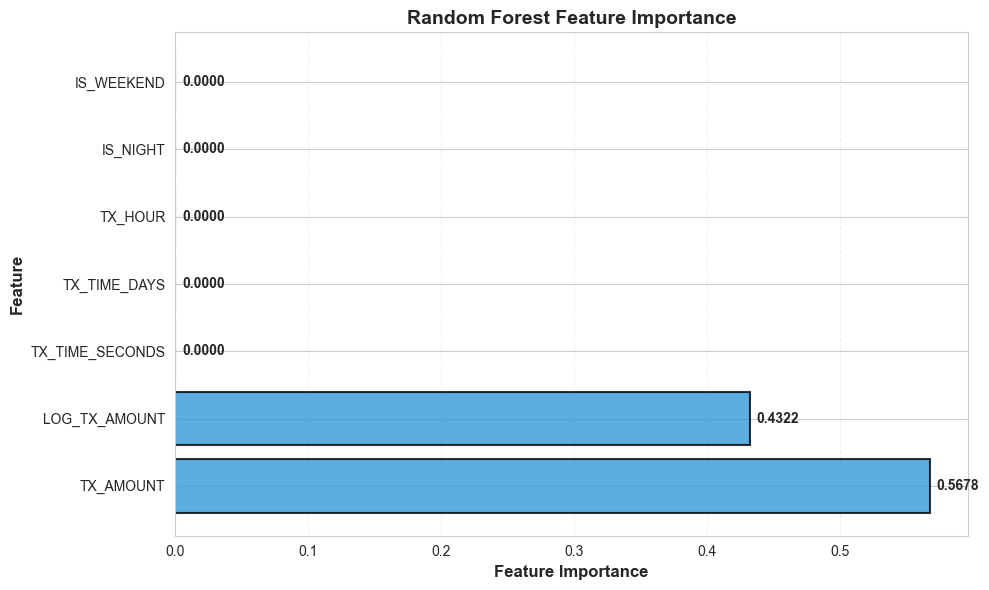

In [8]:
# Visualize Random Forest Feature Importance
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(rf_importance_df['Feature'], rf_importance_df['Importance'], 
               color='#3498db', alpha=0.8, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Feature Importance', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for bar, val in zip(bars, rf_importance_df['Importance']):
    width = bar.get_width()
    ax.text(width + 0.005, bar.get_y() + bar.get_height()/2, 
           f'{val:.4f}', ha='left', va='center', 
           fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


## 4. Comparative Feature Importance Analysis

Comparing feature importance across different models helps identify features that are consistently important (robust across algorithms) and those that are model-specific.


In [9]:
# Normalize all importances to 0-1 scale for comparison
def normalize_importance(importance_array):
    """Normalize importance values to 0-1 scale"""
    total = np.sum(importance_array)
    if total == 0:
        return importance_array
    return importance_array / total

# Normalize LR coefficients (using absolute values)
lr_norm = normalize_importance(np.abs(coefficients))
gbt_norm = normalize_importance(gbt_importances)
rf_norm = normalize_importance(rf_importances)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Feature': feature_cols,
    'Logistic Regression': lr_norm,
    'Gradient Boosting': gbt_norm,
    'Random Forest': rf_norm
})

# Sort by average importance
comparison_df['Average'] = comparison_df[['Logistic Regression', 'Gradient Boosting', 'Random Forest']].mean(axis=1)
comparison_df = comparison_df.sort_values('Average', ascending=False)

print("=" * 80)
print("COMPARATIVE FEATURE IMPORTANCE (Normalized 0-1)")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)


COMPARATIVE FEATURE IMPORTANCE (Normalized 0-1)
        Feature  Logistic Regression  Gradient Boosting  Random Forest  Average
      TX_AMOUNT             0.833106           0.788199   5.677959e-01 0.729700
  LOG_TX_AMOUNT             0.164627           0.211025   4.321969e-01 0.269283
   TX_TIME_DAYS             0.000848           0.000370   2.183404e-06 0.000407
TX_TIME_SECONDS             0.000834           0.000104   4.639260e-06 0.000314
        TX_HOUR             0.000344           0.000279   4.261672e-07 0.000208
     IS_WEEKEND             0.000170           0.000020   0.000000e+00 0.000063
       IS_NIGHT             0.000071           0.000002   0.000000e+00 0.000024


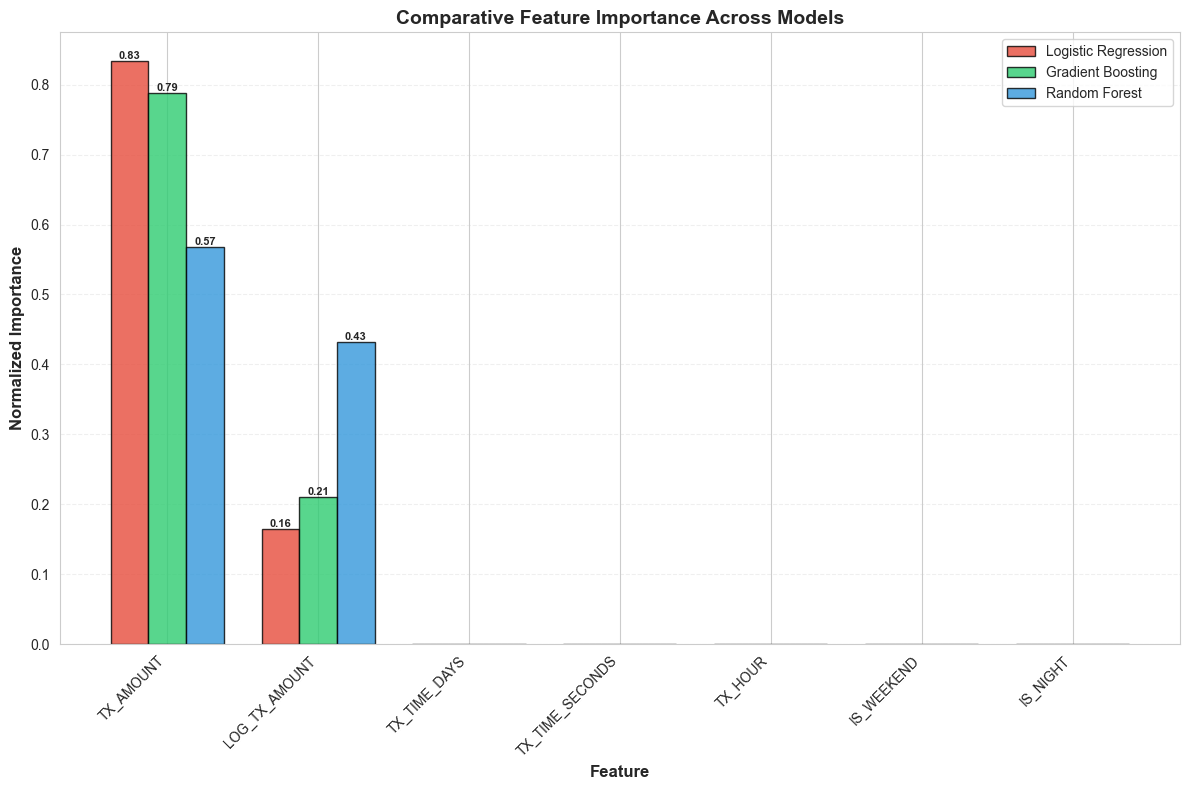

In [10]:
# Visualize comparative feature importance
fig, ax = plt.subplots(figsize=(12, 8))

x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Logistic Regression'], width, 
               label='Logistic Regression', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x, comparison_df['Gradient Boosting'], width, 
               label='Gradient Boosting', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.bar(x + width, comparison_df['Random Forest'], width, 
               label='Random Forest', color='#3498db', alpha=0.8, edgecolor='black')

ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Normalized Importance', fontsize=12, fontweight='bold')
ax.set_title('Comparative Feature Importance Across Models', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right', fontsize=10)
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        if height > 0.01:  # Only label if significant
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}', ha='center', va='bottom', 
                   fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


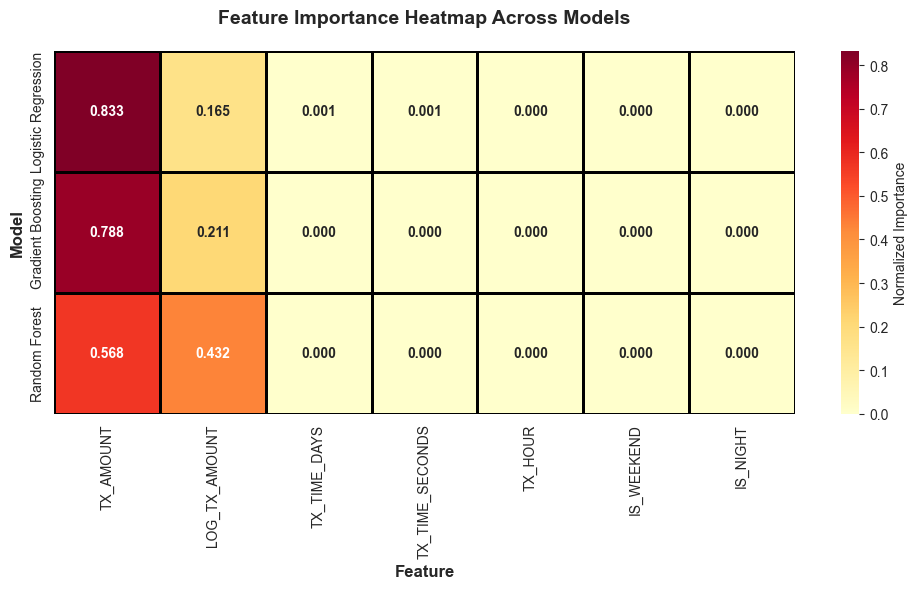

In [11]:
# Create heatmap for better comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for heatmap (transpose)
heatmap_data = comparison_df[['Logistic Regression', 'Gradient Boosting', 'Random Forest']].T
heatmap_data.columns = comparison_df['Feature']

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Normalized Importance'}, 
            linewidths=1, linecolor='black', ax=ax,
            annot_kws={'fontsize': 10, 'fontweight': 'bold'})

ax.set_title('Feature Importance Heatmap Across Models', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


## 5. Feature Rankings

This section ranks features by their average importance across all models, providing a consensus view of which features are most critical for fraud detection.


In [12]:
# Create ranking DataFrame
ranking_df = comparison_df[['Feature', 'Average']].copy()
ranking_df['Rank'] = ranking_df['Average'].rank(ascending=False).astype(int)

# Add individual rankings
lr_rank = comparison_df['Logistic Regression'].rank(ascending=False).astype(int)
gbt_rank = comparison_df['Gradient Boosting'].rank(ascending=False).astype(int)
rf_rank = comparison_df['Random Forest'].rank(ascending=False).astype(int)

ranking_df['LR_Rank'] = lr_rank.values
ranking_df['GBT_Rank'] = gbt_rank.values
ranking_df['RF_Rank'] = rf_rank.values

print("=" * 80)
print("FEATURE RANKINGS ACROSS MODELS")
print("=" * 80)
print(ranking_df.to_string(index=False))
print("\nLower rank number = Higher importance (Rank 1 is most important)")
print("=" * 80)


FEATURE RANKINGS ACROSS MODELS
        Feature  Average  Rank  LR_Rank  GBT_Rank  RF_Rank
      TX_AMOUNT 0.729700     1        1         1        1
  LOG_TX_AMOUNT 0.269283     2        2         2        2
   TX_TIME_DAYS 0.000407     3        3         3        4
TX_TIME_SECONDS 0.000314     4        4         5        3
        TX_HOUR 0.000208     5        5         4        5
     IS_WEEKEND 0.000063     6        6         6        6
       IS_NIGHT 0.000024     7        7         7        6

Lower rank number = Higher importance (Rank 1 is most important)


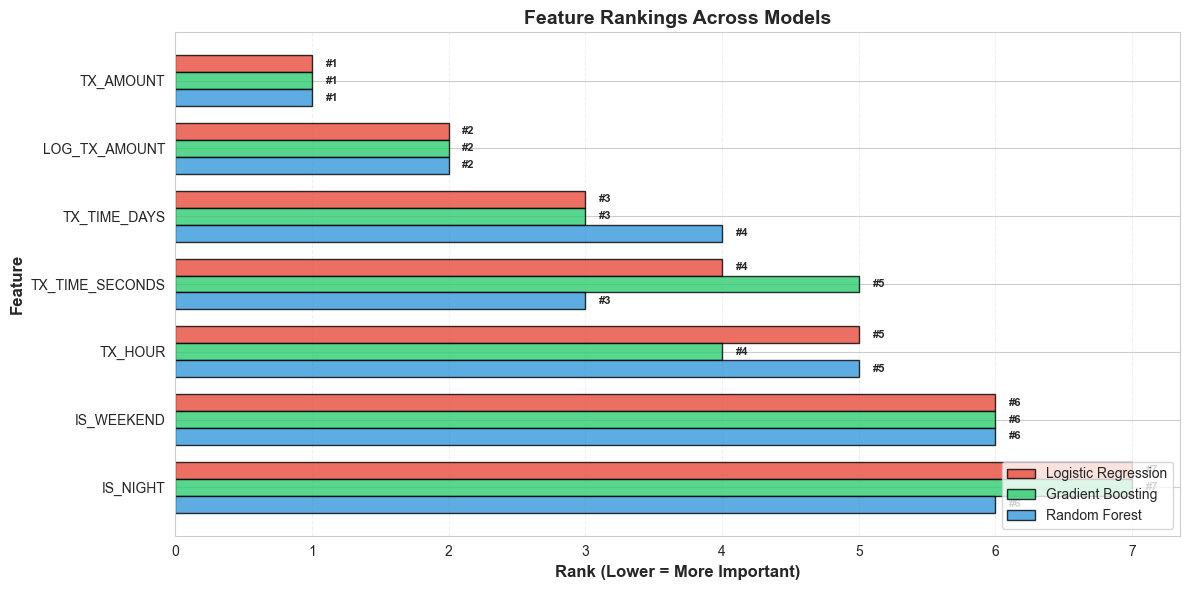

In [13]:
# Visualize rankings
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(ranking_df))
width = 0.25

bars1 = ax.barh(x - width, ranking_df['LR_Rank'], width, 
               label='Logistic Regression', color='#e74c3c', alpha=0.8, edgecolor='black')
bars2 = ax.barh(x, ranking_df['GBT_Rank'], width, 
               label='Gradient Boosting', color='#2ecc71', alpha=0.8, edgecolor='black')
bars3 = ax.barh(x + width, ranking_df['RF_Rank'], width, 
               label='Random Forest', color='#3498db', alpha=0.8, edgecolor='black')

ax.set_xlabel('Rank (Lower = More Important)', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Feature Rankings Across Models', fontsize=14, fontweight='bold')
ax.set_yticks(x)
ax.set_yticklabels(ranking_df['Feature'], fontsize=10)
ax.legend(loc='lower right', fontsize=10)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.invert_yaxis()  # Top feature at top

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        width_bar = bar.get_width()
        ax.text(width_bar + 0.1, bar.get_y() + bar.get_height()/2, 
               f'#{int(width_bar)}', ha='left', va='center', 
               fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()


## 6. Key Insights and Summary

Based on the model interpretation analysis above, here are the key findings:


In [14]:
# Generate summary insights
print("=" * 80)
print("KEY INSIGHTS FROM MODEL INTERPRETATION")
print("=" * 80)

# Top 3 features by average importance
top_3 = ranking_df.nsmallest(3, 'Rank')
print("\n📊 TOP 3 MOST IMPORTANT FEATURES (by average importance):")
for idx, row in top_3.iterrows():
    print(f"   {int(row['Rank'])}. {row['Feature']} (Avg Importance: {row['Average']:.4f})")

# Most consistent feature (lowest standard deviation in rankings)
std_ranks = ranking_df[['LR_Rank', 'GBT_Rank', 'RF_Rank']].std(axis=1)
most_consistent_idx = std_ranks.idxmin()
most_consistent = ranking_df.loc[most_consistent_idx]
print(f"\n🎯 MOST CONSISTENT FEATURE (lowest ranking variance):")
print(f"   {most_consistent['Feature']} (Avg Rank: {most_consistent['Average']:.2f}, Std: {std_ranks[most_consistent_idx]:.2f})")

# LR coefficient insights
print(f"\n📈 LOGISTIC REGRESSION INSIGHTS:")
positive_coef = lr_coef_df[lr_coef_df['Coefficient'] > 0]
negative_coef = lr_coef_df[lr_coef_df['Coefficient'] < 0]
print(f"   Features that INCREASE fraud risk (positive coefficients): {len(positive_coef)}")
for _, row in positive_coef.head(3).iterrows():
    print(f"      - {row['Feature']}: {row['Coefficient']:.4f}")
print(f"   Features that DECREASE fraud risk (negative coefficients): {len(negative_coef)}")
for _, row in negative_coef.head(3).iterrows():
    print(f"      - {row['Feature']}: {row['Coefficient']:.4f}")

# Model agreement
print(f"\n🤝 MODEL AGREEMENT:")
# Find features where all models agree on top 3
top_features_all = set()
for model_col in ['LR_Rank', 'GBT_Rank', 'RF_Rank']:
    top_3_model = set(ranking_df.nsmallest(3, model_col)['Feature'])
    if len(top_features_all) == 0:
        top_features_all = top_3_model
    else:
        top_features_all = top_features_all.intersection(top_3_model)

if len(top_features_all) > 0:
    print(f"   Features in TOP 3 across ALL models: {', '.join(top_features_all)}")
else:
    print(f"   No features consistently ranked in top 3 across all models")

print("\n" + "=" * 80)


KEY INSIGHTS FROM MODEL INTERPRETATION

📊 TOP 3 MOST IMPORTANT FEATURES (by average importance):
   1. TX_AMOUNT (Avg Importance: 0.7297)
   2. LOG_TX_AMOUNT (Avg Importance: 0.2693)
   3. TX_TIME_DAYS (Avg Importance: 0.0004)

🎯 MOST CONSISTENT FEATURE (lowest ranking variance):
   TX_AMOUNT (Avg Rank: 0.73, Std: 0.00)

📈 LOGISTIC REGRESSION INSIGHTS:
   Features that INCREASE fraud risk (positive coefficients): 3
      - TX_AMOUNT: 18.2870
      - TX_TIME_DAYS: 0.0186
      - TX_TIME_SECONDS: 0.0183
   Features that DECREASE fraud risk (negative coefficients): 4
      - LOG_TX_AMOUNT: -3.6136
      - TX_HOUR: -0.0075
      - IS_WEEKEND: -0.0037

🤝 MODEL AGREEMENT:
   Features in TOP 3 across ALL models: LOG_TX_AMOUNT, TX_AMOUNT

